# The Goddard Problem (One Phase)

For a solution to the Goddard problem with one phase using a Python script instead of a notebook, see the [Python script documentation](../scripts/goddard_problem_1_phase.rst).

## Problem Description

Goddard <cite data-footcite="Goddard:1920">(1920)</cite> first posed the problem of determining the maximum height that can be achieved by a rocket. In a 1920 paper in *Nature*, he posed the problem as follows:

> The basic idea of the method, briefly stated in general terms, is this: Given a mass of explosive material of as great energy content as possible, what height can be reached if a large fraction of this material is shot downwards, on exploding, with as high a speed as possible? It is evident, intuitively, that the height will be great if the fraction of material that remains is small and the velocity of ejection of the gases is high.

See Bryson and Ho <cite data-footcite="Bryson:1975">(1975)</cite>, Section 8.3, for a detailed treatment of the Goddard Rocket problem and its history. The specific parameters used here are taken from Betts <cite data-footcite="Betts:2010">(2010)</cite>, Problem 4.9. See also the solution using the GPOPS software package by Rao et al. <cite data-footcite="Rao:2010">(2010)</cite>.

The states of the system are given by
$$
\begin{aligned}
    h(t) &= \text{altitude (ft)} \\
    v(t) &= \text{velocity (ft/s)} \\
    m(t) &= \text{mass (slug)}
\end{aligned}
$$
and the control input is
$$
\begin{aligned}
    u(t) = T(t) = \text{thrust (lbf)}
\end{aligned}
$$
The optimal control problem is to maximize the final height achieved by the rocket,
$$
\begin{equation}
    J = h(t_f)
\end{equation}
$$
subject to the dynamics and the constraints on the thrust. The dynamics are given by
$$
\begin{aligned}
    \dot{h} &= v \\
    \dot{v} &= \frac{1}{m} \left(T - D \right) - g \\
    \dot{m} &= -\frac{T}{c}
\end{aligned}
$$
where the drag $D$ is given by
$$
\begin{aligned}
    D &= \frac{1}{2} \rho(h) v^2 S C_D \\
      &= \frac{1}{2} \rho_0 \exp(-h/h_0) v^2 S C_D \\
      &= \sigma v^2 \exp(-h/h_0)
\end{aligned}
$$
where $\rho(h)=\rho_0 \exp(-h/h_0)$ is the air density as a function of altitude, $h_0$ is the scale height of the atmosphere, $S$ is the reference area of the rocket, $C_D$ is the drag coefficient of the rocket, and therefore
$$
\begin{aligned}
    \sigma &= \frac{1}{2} \rho_0 S C_D
\end{aligned}
$$
The boundary conditions are that
$$
\begin{aligned}
    h(t_0) &= 0 \\
    v(t_0) &= 0 \\
    m(t_0) &= m_0 = 3 \text{ lb} \\
\end{aligned}
$$
and the bounds on the states and control are that
$$
\begin{aligned}
    0 &\le T \le T_\text{max} \\
    m_f &\le m \le m_0
\end{aligned}
$$
The problem constants are given by
$$
\begin{aligned}
    g            &= 32.174 \text{ ft/s}^2 \\
    T_\text{max} &= 200 \text{ lbf} \\
    \sigma       &= 5.4915 \times 10^{-5} \text{ slug/ft}\\
    c            &= 1580.9425 \text{ ft/s} \\
    h_0          &= \text{23,800  ft}
\end{aligned}
$$

## YAPSS Solution

We begin by importing the required Python packages, and instantiating the problem with the proper dimensions:

In [1]:
# third party imports
import matplotlib.pyplot as plt

# package imports
from yapss.math import exp
from yapss import Problem, Solution

problem = Problem(name="One phase Goddard Rocket Problem", nx=[3], nu=[1])

We next define the callback functions, as well as any constants required. Note that no discrete callback function is required because there are no discrete function constraints.

In [2]:
# physical constants
Tm = 200
g = 32.174
sigma = 5.4915e-05
c = 1580.9425
hs = 23800

# callback functions


def objective(arg):
    """Goddard Rocket Problem objective function."""
    arg.objective = arg.phase[0].final_state[0]


def continuous(arg):
    """Goddard Rocket Problem dynamics."""
    h, v, m = arg.phase[0].state
    (T,) = arg.phase[0].control
    dynamics = arg.phase[0].dynamics
    v_dot = (T - sigma * v**2 * exp(-h / hs)) / m - g
    m_dot = -T / c
    dynamics[0] = v
    dynamics[1] = v_dot
    dynamics[2] = m_dot


functions = problem.functions
functions.objective = objective
functions.continuous = continuous

Next, set the bounds. The initial states and times are constrained to be the required values, and the control (the thrust) is limited to allowable values. Loose bounds are set on all other variables, except for the final mass, which is constrained to be $m_f=1$.

In [3]:
# boundary conditions
h0, v0, m0 = 0, 0, 3
mf = 1
hmin, hmax = 0, 30000
vmin, vmax = 0, 15000
t0 = 0
tf_min, tf_max = 20, 100

# bounds
bounds = problem.bounds.phase[0]

# initial conditions
bounds.initial_time.lower = bounds.initial_time.upper = t0
bounds.initial_state.lower[:] = bounds.initial_state.upper[:] = [h0, v0, m0]

# final time
bounds.final_time.lower = tf_min
bounds.final_time.upper = tf_max

# state bounds
bounds.state.lower[:] = [hmin, vmin, mf]
bounds.state.upper[:] = [hmax, vmax, m0]
bounds.final_state.lower[:] = [hmin, vmin, mf]
bounds.final_state.upper[:] = [hmax, vmax, mf]

# control bounds
bounds.control.lower[:] = (0,)
bounds.control.upper[:] = (Tm,)

The initial guess is simply a linear interpolation between plausible initial and final values.

In [4]:
# guess
phase = problem.guess.phase[0]
phase.time = (t0, tf_max)
phase.state = ((hmin, hmax), (v0, 0), (m0, mf))
phase.control = ((Tm, 0),)

We use a mesh with 10 segments, each with 10 collocation points.

In [5]:
# mesh
m, n = 10, 10
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].fraction = m * (1.0 / m,)

Scaling is important for this problem, because the range of some of the states (especially altitude) is large compare to 1. We set ``problem.scale.objective = -1`` because this is a maximization problem rather than a minimization problem.

In [6]:
# scale the problem to make it better conditioned
problem.scale.objective = -1
problem.scale.phase[0].state = problem.scale.phase[0].dynamics = 18_000, 800, 3
problem.scale.phase[0].time = 30

We use the default spectral method and derivatives order and method:

In [7]:
# yapss options
problem.spectral_method = "lgl"
problem.derivatives.order = "second"
problem.derivatives.method = "auto"

# ipopt options
problem.ipopt_options.tol = 1e-20
problem.ipopt_options.print_level = 3

Find the optimal solution:

In [8]:
# find the solution
solution = problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      391
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      361
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 67

     

## Plots

First, we need to extract the data from the solution:

In [9]:
# extract information from solution
time = solution.phase[0].time
time_c = solution.phase[0].time_c
h, v, m = solution.phase[0].state
(T,) = solution.phase[0].control
phase = solution.phase[0]
hamiltonian = sum(phase.costate[i] * phase.dynamics[i] for i in range(3))

# initial and final time
t0 = solution.phase[0].initial_time
tf = solution.phase[0].final_time

### Thrust History

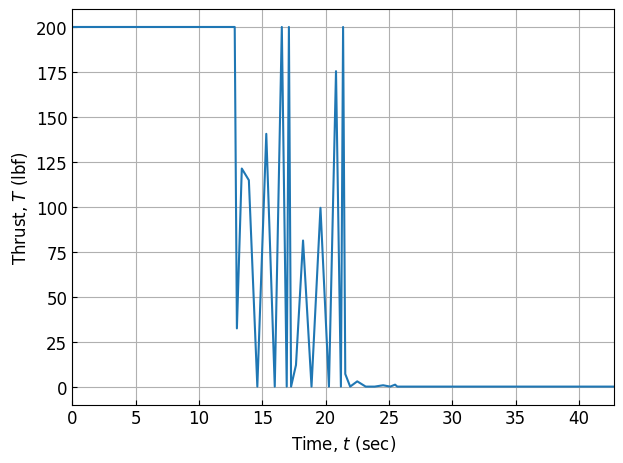

In [10]:
# thrust
plt.figure()
plt.plot(time_c, T)
plt.ylabel("Thrust, $T$ (lbf)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.grid()
plt.tight_layout()

Note that the thrust is constant at the beginning at the end of the problem, but in the middle section between about $t=12.5$ and $t=22$ seconds the solution is quite noisy. The is due to the presence of a *singular arc* in the problem. See this [JupyterLab notebook for the YAPSS solution to this problem taking into account the presence of the singular arc](goddard_problem_3_phase.rst).

### Altitude

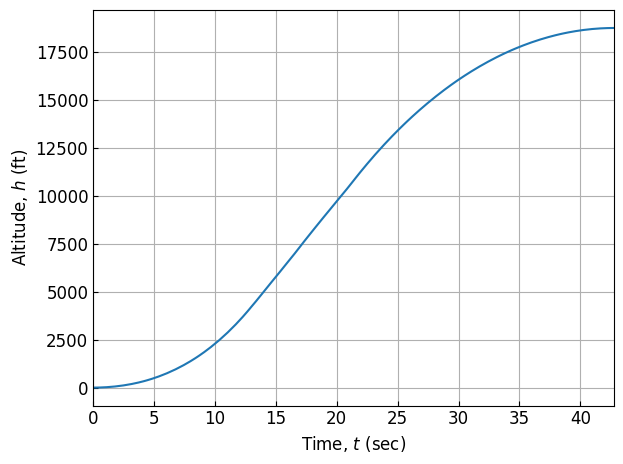

In [11]:
# altitude
plt.figure()
plt.plot(time, h)
plt.ylabel("Altitude, $h$ (ft)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.grid()
plt.tight_layout()

### Velocity

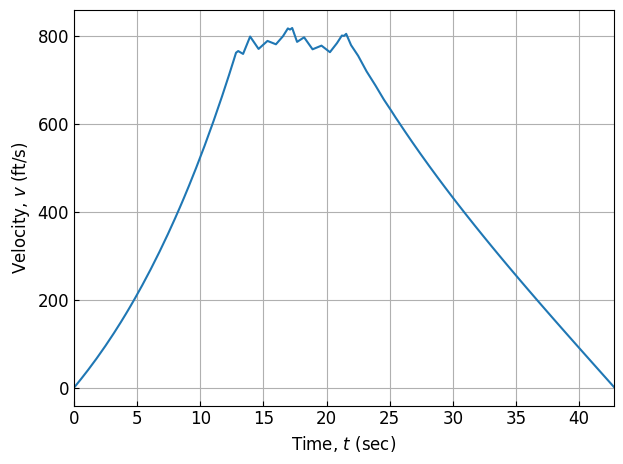

In [12]:
# velocity
plt.figure()
plt.plot(time, v)
plt.ylabel("Velocity, $v$ (ft/s)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.grid()
plt.tight_layout()

Note the raggedness of the velocity state during the singular arc. The velocity plot is less ragged than the thrust plot, because the velocity is the integral of forces on the rocket (including thrust), divided by mass. The action of integration smooths the high-frequency variation in those forces, specifically the thrust. Likewise, altitude is the integral of velocity, and so the altitude plot is smoother still.

### Mass

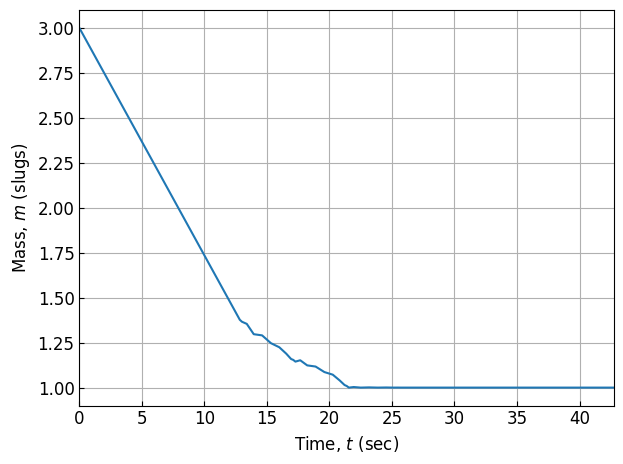

In [13]:
# mass
plt.figure()
plt.plot(time, m)
plt.ylabel("Mass, $m$ (slugs)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.grid()
plt.tight_layout()

Like the velocity plot, the plot of mass is ragged during the singular arc due to the high-frequency variation in the thrust, and hence the rate of change of mass.

### Hamiltonian

Finally, we plot the *Hamiltonian*. A description of the Hamiltonian in optimal control problems is beyond the scope of this documentation, but a key fact to know about the Hamiltonian is that it is constant for optimal control problems with dynamics, cost function integrands, and path functions that are not explicit functions of time. For such problems, a numerical solution that is not constant (at least to a desired precision) is not converged. For this problem, the Hamiltonian is far from constant:

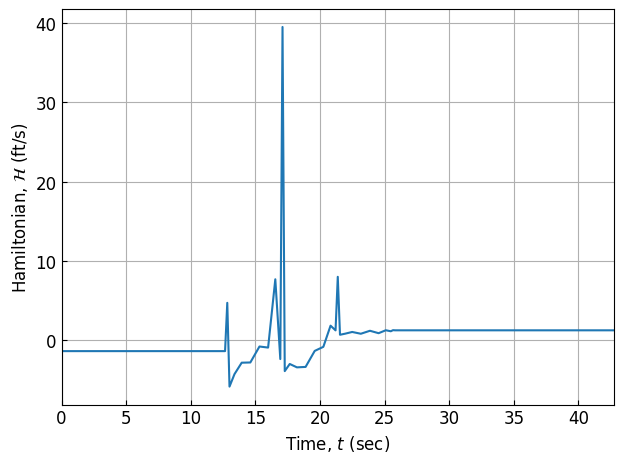

In [14]:
# Hamiltonian
plt.figure()
plt.plot(time_c, hamiltonian)
plt.ylabel(r"Hamiltonian, $\mathcal{H}$ (ft/s)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.grid()
plt.tight_layout()

The Hamiltonian in this case is nearly constant at the beginning and end of the problem time interval, but varies significantly and erratically in the interior, which is a good indication that this problem has a singular arc that is causing a failure of the optimization to converge to the optimal solution.